# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.820886,False,2.324825
1,1.106981,False,1.541308
2,-0.228799,False,-0.176032
3,1.189786,True,9.061684
4,-0.048062,False,0.024091
...,...,...,...
995,0.344893,True,7.700737
996,-0.566948,False,-0.812752
997,0.780920,True,6.846733
998,-0.112680,True,4.861993


<AxesSubplot:xlabel='v0'>

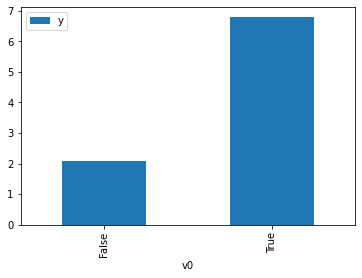

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

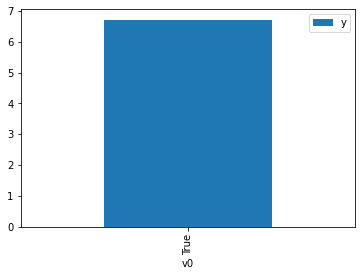

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.943267,False,2.677810,0.377153,2.651441
1,0.636449,False,1.797115,0.404087,2.474712
2,1.067435,False,2.992690,0.366455,2.728845
3,2.178526,False,6.405540,0.277412,3.604749
4,-0.198299,False,-0.748255,0.479880,2.083854
...,...,...,...,...,...
995,1.832809,False,6.028243,0.303687,3.292862
996,1.692308,False,6.120216,0.314758,3.177048
997,0.326045,False,0.767598,0.431937,2.315155
998,0.303574,False,0.352244,0.433972,2.304298


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.210585,True,5.146534,0.518989,1.926825
1,0.218551,True,5.698887,0.558308,1.791125
2,-0.113546,True,4.780393,0.527918,1.894233
3,0.727589,True,7.287106,0.603982,1.655679
4,1.498849,True,8.500817,0.669650,1.493317
...,...,...,...,...,...
995,0.164849,True,5.898366,0.553418,1.806954
996,1.402099,True,9.411331,0.661707,1.511242
997,0.677359,True,5.714381,0.599541,1.667942
998,1.390596,True,8.808935,0.660757,1.513416


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.808e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        12:41:12   Log-Likelihood:                         -1426.7
No. Observations:                1000   AIC:                                      2857.
Df Residuals:                     998   BIC:                                      2867.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5871      0.032     80.992      0.000       2.524       2.650
x2             5.0237      0.049    103.195      0.000       4.928       5.119
==============================================================================
Omnibus:                        1.588   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.600
Skew:                           0.053   Prob(JB):                        0.449
Kurtosis:                       2.836   Cond. No.                         2.09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""